In [1]:
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
import pandas as pd
import numpy as np
import sklearn
import scanpy as sc
import os
import glob
import anndata as ad

In [2]:
nmix=8
num_markers = 20

In [3]:
spatialLIBD_dir = './data/spatialLIBD'

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

adata_dir = os.path.join(spatialLIBD_dir, 'adata')

adata_spatialLIBD_d = {}

for name in glob.glob(os.path.join(adata_dir, 'adata_spatialLIBD-*.h5ad')):
    sample_id = name.partition("-")[2].rpartition(".")[0]
    # print(sample_id)
    adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.4.0
asttokens           NA
backcall            0.2.0
cffi                1.15.1
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           1.2.0
h5py                3.8.0
ipykernel           6.20.2
ipython_genutils    0.2.0
ipywidgets          8.0.4
jedi                0.18.2
joblib              1.2.0
jupyter_server      2.1.0
kiwisolver          1.4.4
llvmlite            0.39.1
matplotlib          3.6.3
mpl_toolkits        NA
natsort             8.2.0
numba               0.56.4
numexpr             2.8.4
numpy               1.23.5
packaging           23.0
pandas              1.5.3
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        2.6.2
prompt_toolkit      3.0.36
psutil              5.9

### Load Single Cell Data

In [4]:
adata_sc_dlpfc = sc.read_h5ad('./data/sc_dlpfc/adata_sc_dlpfc.h5ad')
adata_sc_dlpfc.var_names_make_unique()
sc.pp.normalize_total(adata_sc_dlpfc, inplace=True, target_sum=1e6)

normalizing counts per cell
    finished (0:00:00)


## Find Marker Genes

In [5]:
# #Preprocessing
# adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# # adata_sc_dlpfc_plot = sc.pp.normalize_total(adata_sc_dlpfc)

# #PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
# sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_dlpfc)
# sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
# sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])

In [6]:
# sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
# # sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)
# genelists = adata_sc_dlpfc.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.to_pickle('data/sc_dlpfc/df_genelists.pkl')

In [7]:
df_genelists = pd.read_pickle('data/sc_dlpfc/df_genelists.pkl')
res_genes = []
for column in df_genelists.head(num_markers):
    res_genes.extend(df_genelists.head(num_markers)[column].tolist())
res_genes_ = list(set(res_genes))

# with open('data/res_genes_.json', 'w') as f:
#     json.dump(res_genes_, f)

### Select same gene features 

In [8]:
adata_spatialLIBD = ad.concat(
    adata_spatialLIBD_d.values(), 
    label='sample_id', 
    keys=adata_spatialLIBD_d.keys()
)
adata_spatialLIBD.obs_names_make_unique()
sc.pp.normalize_total(adata_spatialLIBD, inplace=True, target_sum=1e6)

normalizing counts per cell


/projects/wma/AGrEDA/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)


In [9]:
adata_spatialLIBD.var_names_make_unique()
inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
print('Selected Feature Gene number', len(inter_genes))
adata_sc_dlpfc = adata_sc_dlpfc[:, inter_genes]

adata_spatialLIBD = adata_spatialLIBD[:, inter_genes]


Selected Feature Gene number 367


## Format Data

## Generate Pseudospots

In [10]:
from sklearn.preprocessing import OneHotEncoder


def random_mix(Xs, ys, nmix=5, n_samples=10000, seed=0):
    # Define empty lists
    Xs_new, ys_new = [], []
    ys_ = OneHotEncoder().fit_transform(ys.reshape(-1, 1)).toarray()

    rstate = np.random.RandomState(seed)
    fraction_all = rstate.rand(n_samples, nmix)
    randindex_all = rstate.randint(len(Xs), size=(n_samples, nmix))

    for i in range(n_samples):
        # fraction: random fraction across the "nmix" number of sampled cells
        fraction = fraction_all[i]
        fraction = fraction / np.sum(fraction)
        fraction = np.reshape(fraction, (nmix, 1))

        # Random selection of the single cell data by the index
        randindex = randindex_all[i]
        ymix = ys_[randindex]
        # Calculate the fraction of cell types in the cell mixture
        yy = np.sum(ymix * fraction, axis=0)
        # Calculate weighted gene expression of the cell mixture
        XX = np.asarray(Xs[randindex]) * fraction
        XX_ = np.sum(XX, axis=0)

        # Add cell type fraction & composite gene expression in the list
        ys_new.append(yy)
        Xs_new.append(XX_)

    Xs_new = np.asarray(Xs_new)
    ys_new = np.asarray(ys_new)

    return Xs_new, ys_new

In [11]:
def log_minmaxscale(arr):
    arrd = len(arr)
    arr = np.log1p(arr)
    return (arr-np.reshape(np.min(arr,axis=1), (arrd,1)))/np.reshape((np.max(arr, axis=1)-np.min(arr,axis=1)),(arrd,1))

In [12]:
df_sc = adata_sc_dlpfc.to_df()
df_sc.index = pd.MultiIndex.from_frame(adata_sc_dlpfc.obs.reset_index())

sc_sub_dict = dict(zip(range(df_genelists.shape[1]), df_genelists.columns.tolist()))
sc_sub_dict2 = dict((y, x) for x, y in sc_sub_dict.items())

In [13]:
# lab_sc_sub = df_sc.cell_subclass
# sc_sub_dict = dict(zip(range(len(set(lab_sc_sub))), set(lab_sc_sub)))
# sc_sub_dict2 = dict((y,x) for x,y in sc_sub_dict.items())
# lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
# lab_sc_num = np.asarray(lab_sc_num, dtype='int')

sc_mix_l = []
lab_mix_l = []
patient_l = []
for patient, df in df_sc.groupby(level='patient'):
    lab_sc_sub = df.index.get_level_values('cell_subclass')
    lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
    lab_sc_num = np.asarray(lab_sc_num, dtype='int')

    sc_mix, lab_mix = random_mix(
        df.to_numpy(), lab_sc_num, nmix=nmix, n_samples=len(df)
    )

    sc_mix_l.append(pd.DataFrame(np.log1p(sc_mix), columns=df.columns.to_numpy()))
    lab_mix_l.append(
        pd.DataFrame(
            lab_mix, columns=[sc_sub_dict[i] for i in np.unique(lab_sc_num)]
        )
    )
    patient_l.append(patient)

    # print(np.unique(lab_sc_num))

# sc_mix_s = log_minmaxscale(sc_mix)

# mat_sc_s = log_minmaxscale(mat_sc)


In [14]:
sc_mix_df = pd.concat(sc_mix_l, keys=patient_l, names=['subject'])
lab_mix_df = pd.concat(lab_mix_l, keys=patient_l, names=['subject']).fillna(0.)
lab_mix_df = lab_mix_df.reindex(columns=df_genelists.columns)

lab_mix_df['sample_id'] = lab_mix_df.index.get_level_values('subject')
sc_mix_df['sample_id'] = sc_mix_df.index.get_level_values('subject')
lab_mix_df = lab_mix_df.set_index('sample_id', append=True)
sc_mix_df = sc_mix_df.set_index('sample_id', append=True)
lab_mix_df = lab_mix_df.reorder_levels([0,2,1])
sc_mix_df = sc_mix_df.reorder_levels([0,2,1])

display(sc_mix_df)
display(lab_mix_df)

SLC17A7     MAML2      SOX6     XYLT1       PKM  \
subject sample_id                                                          
2       2         0     7.073442  4.381421  5.923700  4.381421  5.038130   
                  1     4.252063  3.587388  3.980171  0.000000  4.569678   
                  2     5.250850  2.932855  5.924202  2.932855  0.973028   
                  3     4.302085  0.000000  0.000000  4.718502  6.104307   
                  4     4.041883  3.444074  6.006989  4.856117  5.666082   
...                          ...       ...       ...       ...       ...   
31      31        3283  3.972081  6.522970  5.148882  2.531754  4.326857   
                  3284  5.128344  3.858496  4.214118  4.212904  4.914910   
                  3285  4.550437  5.528542  5.748261  4.550437  3.906146   
                  3286  6.076510  5.752454  6.259083  5.270313  5.749409   
                  3287  4.998818  3.605985  6.706826  4.106201  4.379872   

                            JUNB    CADPS2   PRELID2      NRP1     ACSS1  ...  \
subject sample_id                                                         ...   
2       2         0     4.381421  5.513030  3.180226  0.000000  3.775876  ...   
                  1     0.000000  3.687383  0.000000  4.569678  6.152063  ...   
                  2     0.000000  5.920318  2.932855  0.000000  5.032195  ...   
                  3     0.000000  6.515868  0.000000  2.254771  0.000000  ...   
                  4     0.000000  5.557723  0.000000  3.444074  0.000000  ...   
...                          ...       ...       ...       ...       ...  ...   
31      31        3283  3.558965  5.849273  2.910491  2.910491  0.000000  ...   
                  3284  2.981104  5.516250  3.078967  4.286937  2.786474  ...   
                  3285  3.540390  4.951116  0.000000  3.321903  0.000000  ...   
                  3286  0.000000  4.569763  0.000000  0.000000  0.000000  ...   
                  3287  2.298023  6.058542  4.902493  2.298023  1.700602  ...   

                            PPIA   TMEM108    SLC6A1    SORBS2   ZNF804B  \
subject sample_id                                                          
2       2         0     5.745184  6.028595  4.261947  5.385244  4.200024   
                  1     0.000000  5.723956  3.980171  5.237408  5.237408   
                  2     6.229711  6.496352  5.924202  6.824507  4.620762   
                  3     6.186062  5.153918  0.000000  6.228650  5.604188   
                  4     6.242885  6.769535  4.037597  5.767123  4.288186   
...                          ...       ...       ...       ...       ...   
31      31        3283  2.910491  3.734700  4.468482  4.846689  6.703270   
                  3284  3.858316  6.261212  3.448318  5.497115  6.234521   
                  3285  3.321903  5.673072  2.110371  5.276066  5.819405   
                  3286  5.563301  5.434827  0.000000  5.931479  5.755636   
                  3287  1.700602  6.098524  3.042479  5.819327  6.412958   

                          LRRC4C      RTN1        TF    IFITM3     CALM1  
subject sample_id                                                         
2       2         0     6.452573  6.245695  4.320549  0.000000  6.795736  
                  1     6.547796  6.001854  3.587388  0.000000  6.226569  
                  2     6.539226  5.789538  4.604425  0.000000  5.536272  
                  3     6.907554  6.855949  0.000000  0.000000  7.460535  
                  4     7.395850  6.616328  0.000000  0.000000  7.091395  
...                          ...       ...       ...       ...       ...  
31      31        3283  6.019631  6.005547  5.871403  0.000000  5.286789  
                  3284  7.112543  6.543150  0.000000  0.000000  6.066794  
                  3285  7.055014  8.152955  3.906146  3.906146  6.667176  
                  3286  7.157265  6.386820  5.409843  0.000000  6.913639  
                  3287  5.625419  7.034564  0.000000  0.000000  5.967692  

[35212 rows x 367

Astros_1  Astros_2  Astros_3  Endo  Ex_1_L5_6  \
subject sample_id                                                       
2       2         0          0.0  0.000000  0.000000   0.0        0.0   
                  1          0.0  0.000000  0.000000   0.0        0.0   
                  2          0.0  0.224540  0.157588   0.0        0.0   
                  3          0.0  0.000000  0.000000   0.0        0.0   
                  4          0.0  0.130043  0.000000   0.0        0.0   
...                          ...       ...       ...   ...        ...   
31      31        3283       0.0  0.000000  0.000000   0.0        0.0   
                  3284       0.0  0.000000  0.000000   0.0        0.0   
                  3285       0.0  0.112475  0.000000   0.0        0.0   
                  3286       0.0  0.037498  0.000000   0.0        0.0   
                  3287       0.0  0.000000  0.013441   0.0        0.0   

                        Ex_2_L5  Ex_3_L4_5  Ex_4_L_6   Ex_5_L5  Ex_6_L4_6  \
subject sample_id                                                           
2       2         0         0.0   0.000000  0.000000  0.113268   0.000000   
                  1         0.0   0.000000  0.000000  0.000000   0.000000   
                  2         0.0   0.000000  0.000000  0.000000   0.000000   
                  3         0.0   0.000000  0.000000  0.202599   0.000000   
                  4         0.0   0.000000  0.000000  0.000000   0.000000   
...                         ...        ...       ...       ...        ...   
31      31        3283      0.0   0.000000  0.000000  0.000000   0.000000   
                  3284      0.0   0.000000  0.000000  0.007477   0.000000   
                  3285      0.0   0.000000  0.000000  0.000000   0.000000   
                  3286      0.0   0.199066  0.000000  0.073216   0.000000   
                  3287      0.0   0.000000  0.038811  0.040050   0.142095   

                        ...  Mix_1     Mix_2  Mix_3    Mix_4    Mix_5  OPCs_1  \
subject sample_id       ...                                                     
2       2         0     ...    0.0  0.088068    0.0  0.00000  0.00000   0.000   
                  1     ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   
                  2     ...    0.0  0.000000    0.0  0.14138  0.00000   0.000   
                  3     ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   
                  4     ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   
...                     ...    ...       ...    ...      ...      ...     ...   
31      31        3283  ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   
                  3284  ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   
                  3285  ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   
                  3286  ...    0.0  0.000000    0.0  0.00000  0.04345   0.144   
                  3287  ...    0.0  0.000000    0.0  0.00000  0.00000   0.000   

                        OPCs_2  Oligos_1  Oligos_2  Oligos_3  
subject sample_id                                             
2       2         0        0.0       0.0       0.0  0.000000  
                  1        0.0       0.0       0.0  0.016445  
                  2        0.0       0.0       0.0  0.144754  
                  3        0.0       0.0       0.0  0.000000  
                  4        0.0       0.0       0.0  0.000000  
...                        ...       ...       ...       ...  
31      31        3283     0.0       0.0       0.0  0.324622  
                  3284     0.0       0.0       0.0  0.195517  
                  3285     0.0       0.0       0.0  0.139156  
                  3286     0.0       0.0       0.0  0.040179  
                  3287     0.0       0.0       0.0  0.309524  

[35212 rows x 33 columns]

In [15]:
mat_sp = adata_spatialLIBD.X.todense()

# mat_sp_s = log_minmaxscale(mat_sp)

mat_sp_s_df = pd.DataFrame(np.log1p(mat_sp))
mat_sp_s_df.index = pd.MultiIndex.from_arrays(
    [
        adata_spatialLIBD.obs.subject,
        adata_spatialLIBD.obs.sample_id,
        mat_sp_s_df.index
    ]
)
mat_sp_s_df.columns = adata_spatialLIBD.var_names
mat_sp_s_df

SLC17A7  MAML2  SOX6  XYLT1       PKM      JUNB  \
subject sample_id                                                           
Br5292  151509    0      0.000000    0.0   0.0    0.0  7.695668  0.000000   
                  1      5.929090    0.0   0.0    0.0  5.929090  0.000000   
                  2      7.137544    0.0   0.0    0.0  6.732476  0.000000   
                  3      6.873906    0.0   0.0    0.0  6.873906  0.000000   
                  4      7.017166    0.0   0.0    0.0  6.324914  0.000000   
...                           ...    ...   ...    ...       ...       ...   
Br5595  151669    47676  6.392226    0.0   0.0    0.0  6.902381  5.296957   
                  47677  6.825972    0.0   0.0    0.0  5.911307  0.000000   
                  47678  6.522830    0.0   0.0    0.0  6.810145  0.000000   
                  47679  7.288237    0.0   0.0    0.0  0.000000  5.681529   
                  47680  0.000000    0.0   0.0    0.0  6.824502  0.000000   

                           CADPS2  PRELID2  NRP1     ACSS1  ...      PPIA  \
subject sample_id                                           ...             
Br5292  151509    0      0.000000      0.0   0.0  6.310737  ...  0.000000   
                  1      0.000000      0.0   0.0  0.000000  ...  7.313387   
                  2      0.000000      0.0   0.0  0.000000  ...  6.732476   
                  3      0.000000      0.0   0.0  0.000000  ...  7.096843   
                  4      5.920344      0.0   0.0  0.000000  ...  7.422332   
...                           ...      ...   ...       ...  ...       ...   
Br5595  151669    47676  0.000000      0.0   0.0  0.000000  ...  7.489721   
                  47677  0.000000      0.0   0.0  0.000000  ...  7.162134   
                  47678  0.000000      0.0   0.0  5.427153  ...  7.620462   
                  47679  5.681529      0.0   0.0  0.000000  ...  7.624513   
                  47680  0.000000      0.0   0.0  0.000000  ...  6.824502   

                         TMEM108    SLC6A1    SORBS2  ZNF804B    LRRC4C  \
subject sample_id                                                         
Br5292  151509    0          0.0  0.000000  0.000000      0.0  0.000000   
                  1          0.0  0.000000  0.000000      0.0  0.000000   
                  2          0.0  6.040520  0.000000      0.0  0.000000   
                  3          0.0  6.181793  0.000000      0.0  0.000000   
                  4          0.0  5.229878  0.000000      0.0  0.000000   
...                          ...       ...       ...      ...       ...   
Br5595  151669    47676      0.0  5.296957  0.000000      0.0  0.000000   
                  47677      0.0  0.000000  0.000000      0.0  0.000000   
                  47678      0.0  6.118100  5.427153      0.0  5.427153   
                  47679      0.0  5.681529  0.000000      0.0  5.681529   
                  47680      0.0  6.132441  0.000000      0.0  0.000000   

                             RTN1        TF    IFITM3     CALM1  
subject sample_id                                                
Br5292  151509    0      6.310737  0.000000  0.000000  7.002975  
                  1      7.025928  0.000000  6.620906  7.025928  
                  2      8.235626  0.000000  0.000000  7.425028  
                  3      6.586569  0.000000  6.181793  8.259424  
                  4      7.422332  0.000000  0.000000  7.789873  
...                           ...       ...       ...       ...  
Br5595  151669    47676  7.595026  5.296957  6.392226  7.777264  
                  47677  7.162134  0.000000  0.000000  7.780815  
                  47678  6.522830  5.427153  5.427153  7.821044  
                  47679  7.065264  0.000000  0.000000  6.777866  
                  47680  7.229604  0.000000  6.132441  6.132441  

[47681 rows x 367 columns]

In [16]:
# from sklearn.preprocessing import StandardScaler



# sc_mix_s_df = pd.DataFrame(sc_mix_s)
# sc_mix_s_df.index = pd.MultiIndex.from_arrays([[0 for _ in range(len(sc_mix_s_df))], sc_mix_s_df.index])
# sc_mix_s_df

# sc_mix_s_df = StandardScaler().fit_transform(sc_mix_s_df.loc[0])

In [17]:
import umap
from sklearn.decomposition import PCA


from sklearn.manifold import TSNE


def get_PCA_2D(X):
    pca = PCA(n_components=2)
    pca.fit(X)
    return pca.transform(X)

def plot_scatter(X, labels, legend=None, title=""):
    markers=['o','o','o','^']
    n_clusters = labels.max() + 1
    
    if legend is None:
        legend = [str(i) for i in range(n_clusters)]
    
    for i in range(n_clusters):
        points = np.array([X[j] for j in range(len(X)) if labels[j] == i])
        print(i, len(points))
        plt.scatter(points[:, 0], points[:, 1], label=legend[i], marker=markers[i%len(markers)])
    
    if labels.min()==-1:
        points = np.array([X[j] for j in range(len(X)) if labels[j] == -1])
        plt.scatter(points[:, 0], points[:, 1], c='black', label='-1')
     
    plt.title(title)
    plt.legend()
    # plt.show()
    
def plot_scatter_subfig(X, labels, ax, legend=None, title=""):
    markers=['.','.','o','^']
    n_clusters = labels.max() + 1
    if legend is None:
        legend = [str(i) for i in range(n_clusters)]
        
    for i in range(n_clusters):
        points = np.array([X[j] for j in range(len(X)) if labels[j] == i])
        ax.scatter(points[:, 0], points[:, 1], label=legend[i], marker=markers[i%len(markers)])
    ax.legend(legend)
    if labels.min()==-1:
        points = np.array([X[j] for j in range(len(X)) if labels[j] == -1])
        ax.scatter(points[:, 0], points[:, 1], c='black', label='-1')
        
    ax.set_title(title)

In [18]:
# for sample_id in all_z_df.loc[1].index.get_level_values(0).unique():
#     all_z_df.loc[(1, sample_id)] = StandardScaler().fit_transform(all_z_df.loc[(1, sample_id)])

In [19]:
all_df = pd.concat([sc_mix_df, mat_sp_s_df], keys = ['single-cell', 'spatial'], names=['domain'])

In [20]:
all_df

SLC17A7     MAML2      SOX6     XYLT1  \
domain      subject sample_id                                                 
single-cell 2       2         0      7.073442  4.381421  5.923700  4.381421   
                              1      4.252063  3.587388  3.980171  0.000000   
                              2      5.250850  2.932855  5.924202  2.932855   
                              3      4.302085  0.000000  0.000000  4.718502   
                              4      4.041883  3.444074  6.006989  4.856117   
...                                       ...       ...       ...       ...   
spatial     Br5595  151669    47676  6.392226  0.000000  0.000000  0.000000   
                              47677  6.825972  0.000000  0.000000  0.000000   
                              47678  6.522830  0.000000  0.000000  0.000000   
                              47679  7.288237  0.000000  0.000000  0.000000   
                              47680  0.000000  0.000000  0.000000  0.000000   

                                          PKM      JUNB    CADPS2   PRELID2  \
domain      subject sample_id                                                 
single-cell 2       2         0      5.038130  4.381421  5.513030  3.180226   
                              1      4.569678  0.000000  3.687383  0.000000   
                              2      0.973028  0.000000  5.920318  2.932855   
                              3      6.104307  0.000000  6.515868  0.000000   
                              4      5.666082  0.000000  5.557723  0.000000   
...                                       ...       ...       ...       ...   
spatial     Br5595  151669    47676  6.902381  5.296957  0.000000  0.000000   
                              47677  5.911307  0.000000  0.000000  0.000000   
                              47678  6.810145  0.000000  0.000000  0.000000   
                              47679  0.000000  5.681529  5.681529  0.000000   
                              47680  6.824502  0.000000  0.000000  0.000000   

                                         NRP1     ACSS1  ...      PPIA  \
domain      subject sample_id                            ...             
single-cell 2       2         0      0.000000  3.775876  ...  5.745184   
                              1      4.569678  6.152063  ...  0.000000   
                              2      0.000000  5.032195  ...  6.229711   
                              3      2.254771  0.000000  ...  6.186062   
                              4      3.444074  0.000000  ...  6.242885   
...                                       ...       ...  ...       ...   
spatial     Br5595  151669    47676  0.000000  0.000000  ...  7.489721   
                              47677  0.000000  0.000000  ...  7.162134   
                              47678  0.000000  5.427153  ...  7.620462   
                              47679  0.000000  0.000000  ...  7.624513   
                              47680  0.000000  0.000000  ...  6.824502   

                                      TMEM108    SLC6A1    SORBS2   ZNF804B  \
domain      subject sample_id                                                 
single-cell 2       2         0      6.028595  4.261947  5.385244  4.200024   
                              1      5.723956  3.980171  5.237408  5.237408   
                              2      6.496352  5.924202  6.824507  4.620762   
                              3      5.153918  0.000000  6.228650  5.604188   
                              4      6.769535  4.037597  5.767123  4.288186   
...                                       ...       ...       ...       ...   
spatial     Br5595  151669    47676  0.000000  5.296957  0.000000  0.000000   
                              47677  0.000000  0.000000  0.000000  0.000000   
                              47678  0.000000  6.118100  5.427153  0.000000   
                              47679  0.000000  5.681529  0.000000  0.000000   
                              47680  0.000000  6.132441  0.000000  0.00

In [21]:
from sklearn.preprocessing import StandardScaler

for domain in all_df.index.get_level_values(0).unique():
    all_df.loc[(domain, slice(None), slice(None))] = StandardScaler().fit_transform(all_df.loc[(domain, slice(None), slice(None))])

In [22]:
all_df

SLC17A7     MAML2      SOX6     XYLT1  \
domain      subject sample_id                                                 
single-cell 2       2         0      1.171535  0.501626  0.864624  0.099783   
                              1     -1.031150  0.168741 -0.024839 -2.508987   
                              2     -0.251385 -0.105662  0.864853 -0.762717   
                              3     -0.992097 -1.335214 -1.846378  0.300487   
                              4     -1.195240  0.108659  0.902741  0.382424   
...                                       ...       ...       ...       ...   
spatial     Br5595  151669    47676  0.406439 -0.115214 -0.170549 -0.261843   
                              47677  0.566348 -0.115214 -0.170549 -0.261843   
                              47678  0.454589 -0.115214 -0.170549 -0.261843   
                              47679  0.736772 -0.115214 -0.170549 -0.261843   
                              47680 -1.950186 -0.115214 -0.170549 -0.261843   

                                          PKM      JUNB    CADPS2   PRELID2  \
domain      subject sample_id                                                 
single-cell 2       2         0     -0.343183  1.292266  0.182108  0.327821   
                              1     -0.714759 -0.843450 -1.200817 -1.137885   
                              2     -3.567623 -0.843450  0.490628  0.213812   
                              3      0.502509 -0.843450  0.941756 -1.137885   
                              4      0.154908 -0.843450  0.215963 -1.137885   
...                                       ...       ...       ...       ...   
spatial     Br5595  151669    47676  0.437811  2.032574 -0.430703 -0.058959   
                              47677  0.023980 -0.447531 -0.430703 -0.058959   
                              47678  0.399296 -0.447531 -0.430703 -0.058959   
                              47679 -2.444330  2.212636  2.357342 -0.058959   
                              47680  0.405291 -0.447531 -0.430703 -0.058959   

                                         NRP1     ACSS1  ...      PPIA  \
domain      subject sample_id                            ...             
single-cell 2       2         0     -1.207899  0.860879  ...  0.452919   
                              1      1.041058  1.866008  ... -2.973724   
                              2     -1.207899  1.392303  ...  0.741908   
                              3     -0.098218 -0.736319  ...  0.715875   
                              4      0.487094 -0.736319  ...  0.749766   
...                                       ...       ...  ...       ...   
spatial     Br5595  151669    47676 -0.196431 -0.311122  ...  0.403669   
                              47677 -0.196431 -0.311122  ...  0.224510   
                              47678 -0.196431  3.026586  ...  0.475171   
                              47679 -0.196431 -0.311122  ...  0.477387   
                              47680 -0.196431 -0.311122  ...  0.039858   

                                      TMEM108    SLC6A1    SORBS2   ZNF804B  \
domain      subject sample_id                                                 
single-cell 2       2         0      0.585002  0.301074  0.171570 -0.650443   
                              1      0.320561  0.175385  0.051199  0.035629   
                              2      0.991038  1.042534  1.343455 -0.372188   
                              3     -0.174259 -1.599998  0.858293  0.278198   
                              4      1.228174  0.201000  0.482506 -0.592137   
...                                       ...       ...       ...       ...   
spatial     Br5595  151669    47676 -0.221615  1.002971 -0.441233 -0.015140   
                              47677 -0.221615 -0.810480 -0.441233 -0.015140   
                              47678 -0.221615  1.284094  2.141560 -0.015140   
                              47679 -0.221615  1.134631 -0.441233 -0.015140   
                              47680 -0.221615  1.289004 -0.441233 -0.01

In [23]:
# data_pca = get_PCA_2D(all_df)
# data_umap = umap.UMAP().fit_transform(all_df)
# data_tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=374).fit_transform(all_df)

data_pca_z = get_PCA_2D(all_df)
data_umap_z = umap.UMAP().fit_transform(all_df)
data_tsne_z = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=374).fit_transform(all_df)

/projects/wma/AGrEDA/.venv/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [24]:
data_pca_z_df = pd.DataFrame(data_pca_z, index=all_df.index).reset_index()
data_umap_df = pd.DataFrame(data_umap_z, index=all_df.index).reset_index()
data_tsne_z_df = pd.DataFrame(data_tsne_z, index=all_df.index).reset_index()


data_pca_z_df['sample_id'] = data_pca_z_df['sample_id'].apply(str)
data_umap_df['sample_id'] = data_umap_df['sample_id'].apply(str)
data_tsne_z_df['sample_id'] = data_tsne_z_df['sample_id'].apply(str)

In [25]:
data_pca_z_df[data_pca_z_df['domain'] == domain]

,domain,subject,sample_id,level_3,0,1
35212,spatial,Br5292,151509,0,3.110048,-2.656039
35213,spatial,Br5292,151509,1,-0.610701,0.952882
35214,spatial,Br5292,151509,2,-0.420585,0.794230
35215,spatial,Br5292,151509,3,-3.799434,1.160868
35216,spatial,Br5292,151509,4,-3.541765,2.582474
...,...,...,...,...,...,...
82888,spatial,Br5595,151669,47676,-0.919437,2.707627
82889,spatial,Br5595,151669,47677,-3.011346,2.091331
82890,spatial,Br5595,151669,47678,-2.739328,0.441370
82891,spatial,Br5595,151669,47679,-0.503394,1.348498


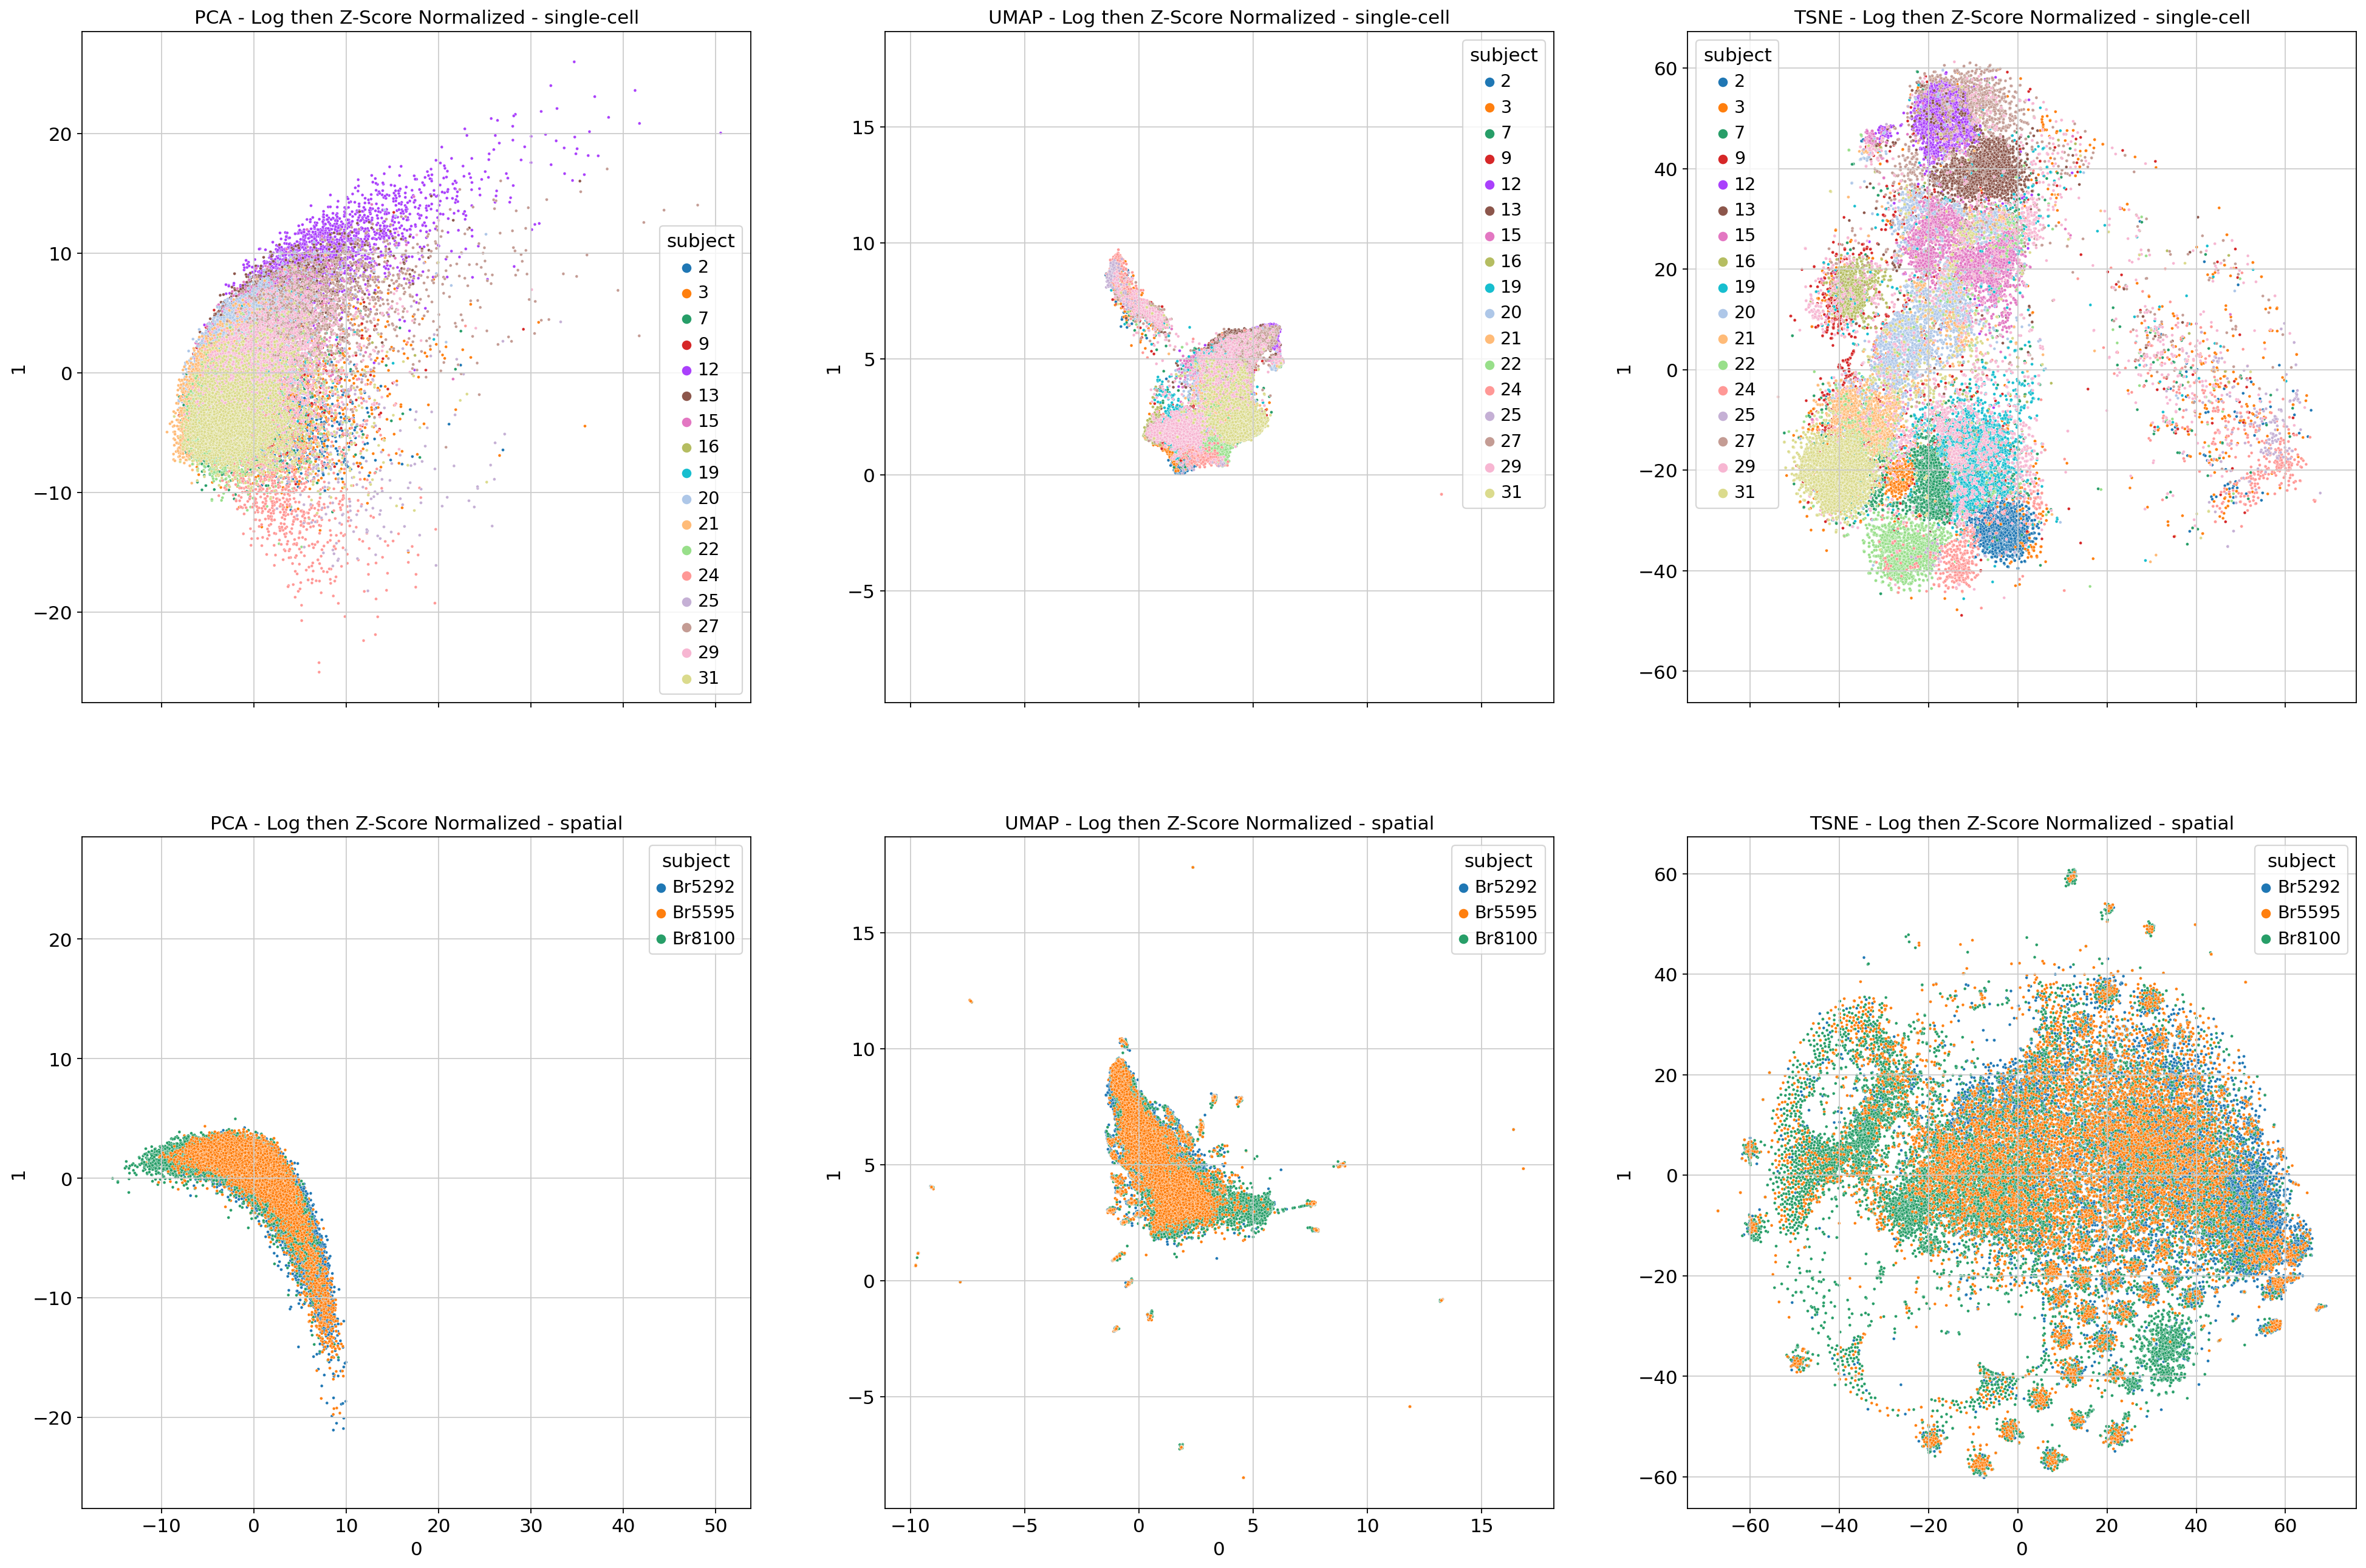

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(30, 20), sharex='col', sharey='col')
# plot_scatter_subfig(data_pca, all_df.index.get_level_values(0).to_numpy(), axs[0][0], title=f'PCA - Min-Max Normalized', legend=['sc', 'st'])
# plot_scatter_subfig(data_umap, all_df.index.get_level_values(0).to_numpy(), axs[0][1], title=f'UMAP - Min-Max Normalized', legend=['sc', 'st'])

# plot_scatter_subfig(data_pca_z, all_df.index.get_level_values(0).to_numpy(), axs[0], title=f'PCA - Log then Z-Score Normalized', legend=['sc', 'st'])
# plot_scatter_subfig(data_umap_z, all_df.index.get_level_values(0).to_numpy(), axs[1], title=f'UMAP - Log then Z-Score Normalized', legend=['sc', 'st'])
# plot_scatter_subfig(data_tsne_z, all_df.index.get_level_values(0).to_numpy(), axs[2], title=f'TSNE - Log then Z-Score Normalized', legend=['sc', 'st'])

# markers = {'single-cell': '_', 'spatial': '|'}
for i, domain in enumerate(data_pca_z_df['domain'].unique()):
    sns.scatterplot(
        data=data_pca_z_df[data_pca_z_df['domain'] == domain],
        x = 0,
        y = 1,
        # style=all_df.index.get_level_values(0),
        hue='subject',
        s=5,
        # markers=markers,
        ax=axs[i][0],
    )
    sns.scatterplot(
        data=data_umap_df[data_umap_df['domain'] == domain],
            x = 0,
        y = 1,
        # style=all_df.index.get_level_values(0),
        hue='subject',
        # markers=markers,
        s=5,
        ax=axs[i][1]
    )
    sns.scatterplot(
        data=data_tsne_z_df[data_tsne_z_df['domain'] == domain],
            x = 0,
        y = 1,
        # style=all_df.index.get_level_values(0),
        hue='subject',
        # markers=markers,
        s=5,
        ax=axs[i][2]
    )

    axs[i][0].set_title(f'PCA - Log then Z-Score Normalized - {domain}')
    axs[i][1].set_title(f'UMAP - Log then Z-Score Normalized - {domain}')
    axs[i][2].set_title(f'TSNE - Log then Z-Score Normalized - {domain}')

# fig.suptitle(f'Single Cell (DLPFC Nagy et al. controls, pseudo-spots of n=8) vs Spatial Transcriptomic (spatialLIBD DLPFC sample {all_z_df.loc[1].index.get_level_values(0)[0]})')

plt.show(block=False)

In [27]:
Z = sch.linkage(all_df, method='ward', metric = 'euclidean')

/tmp/ipykernel_1528474/1644917950.py:76: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(neg, cax=cbaxes, orientation='horizontal',


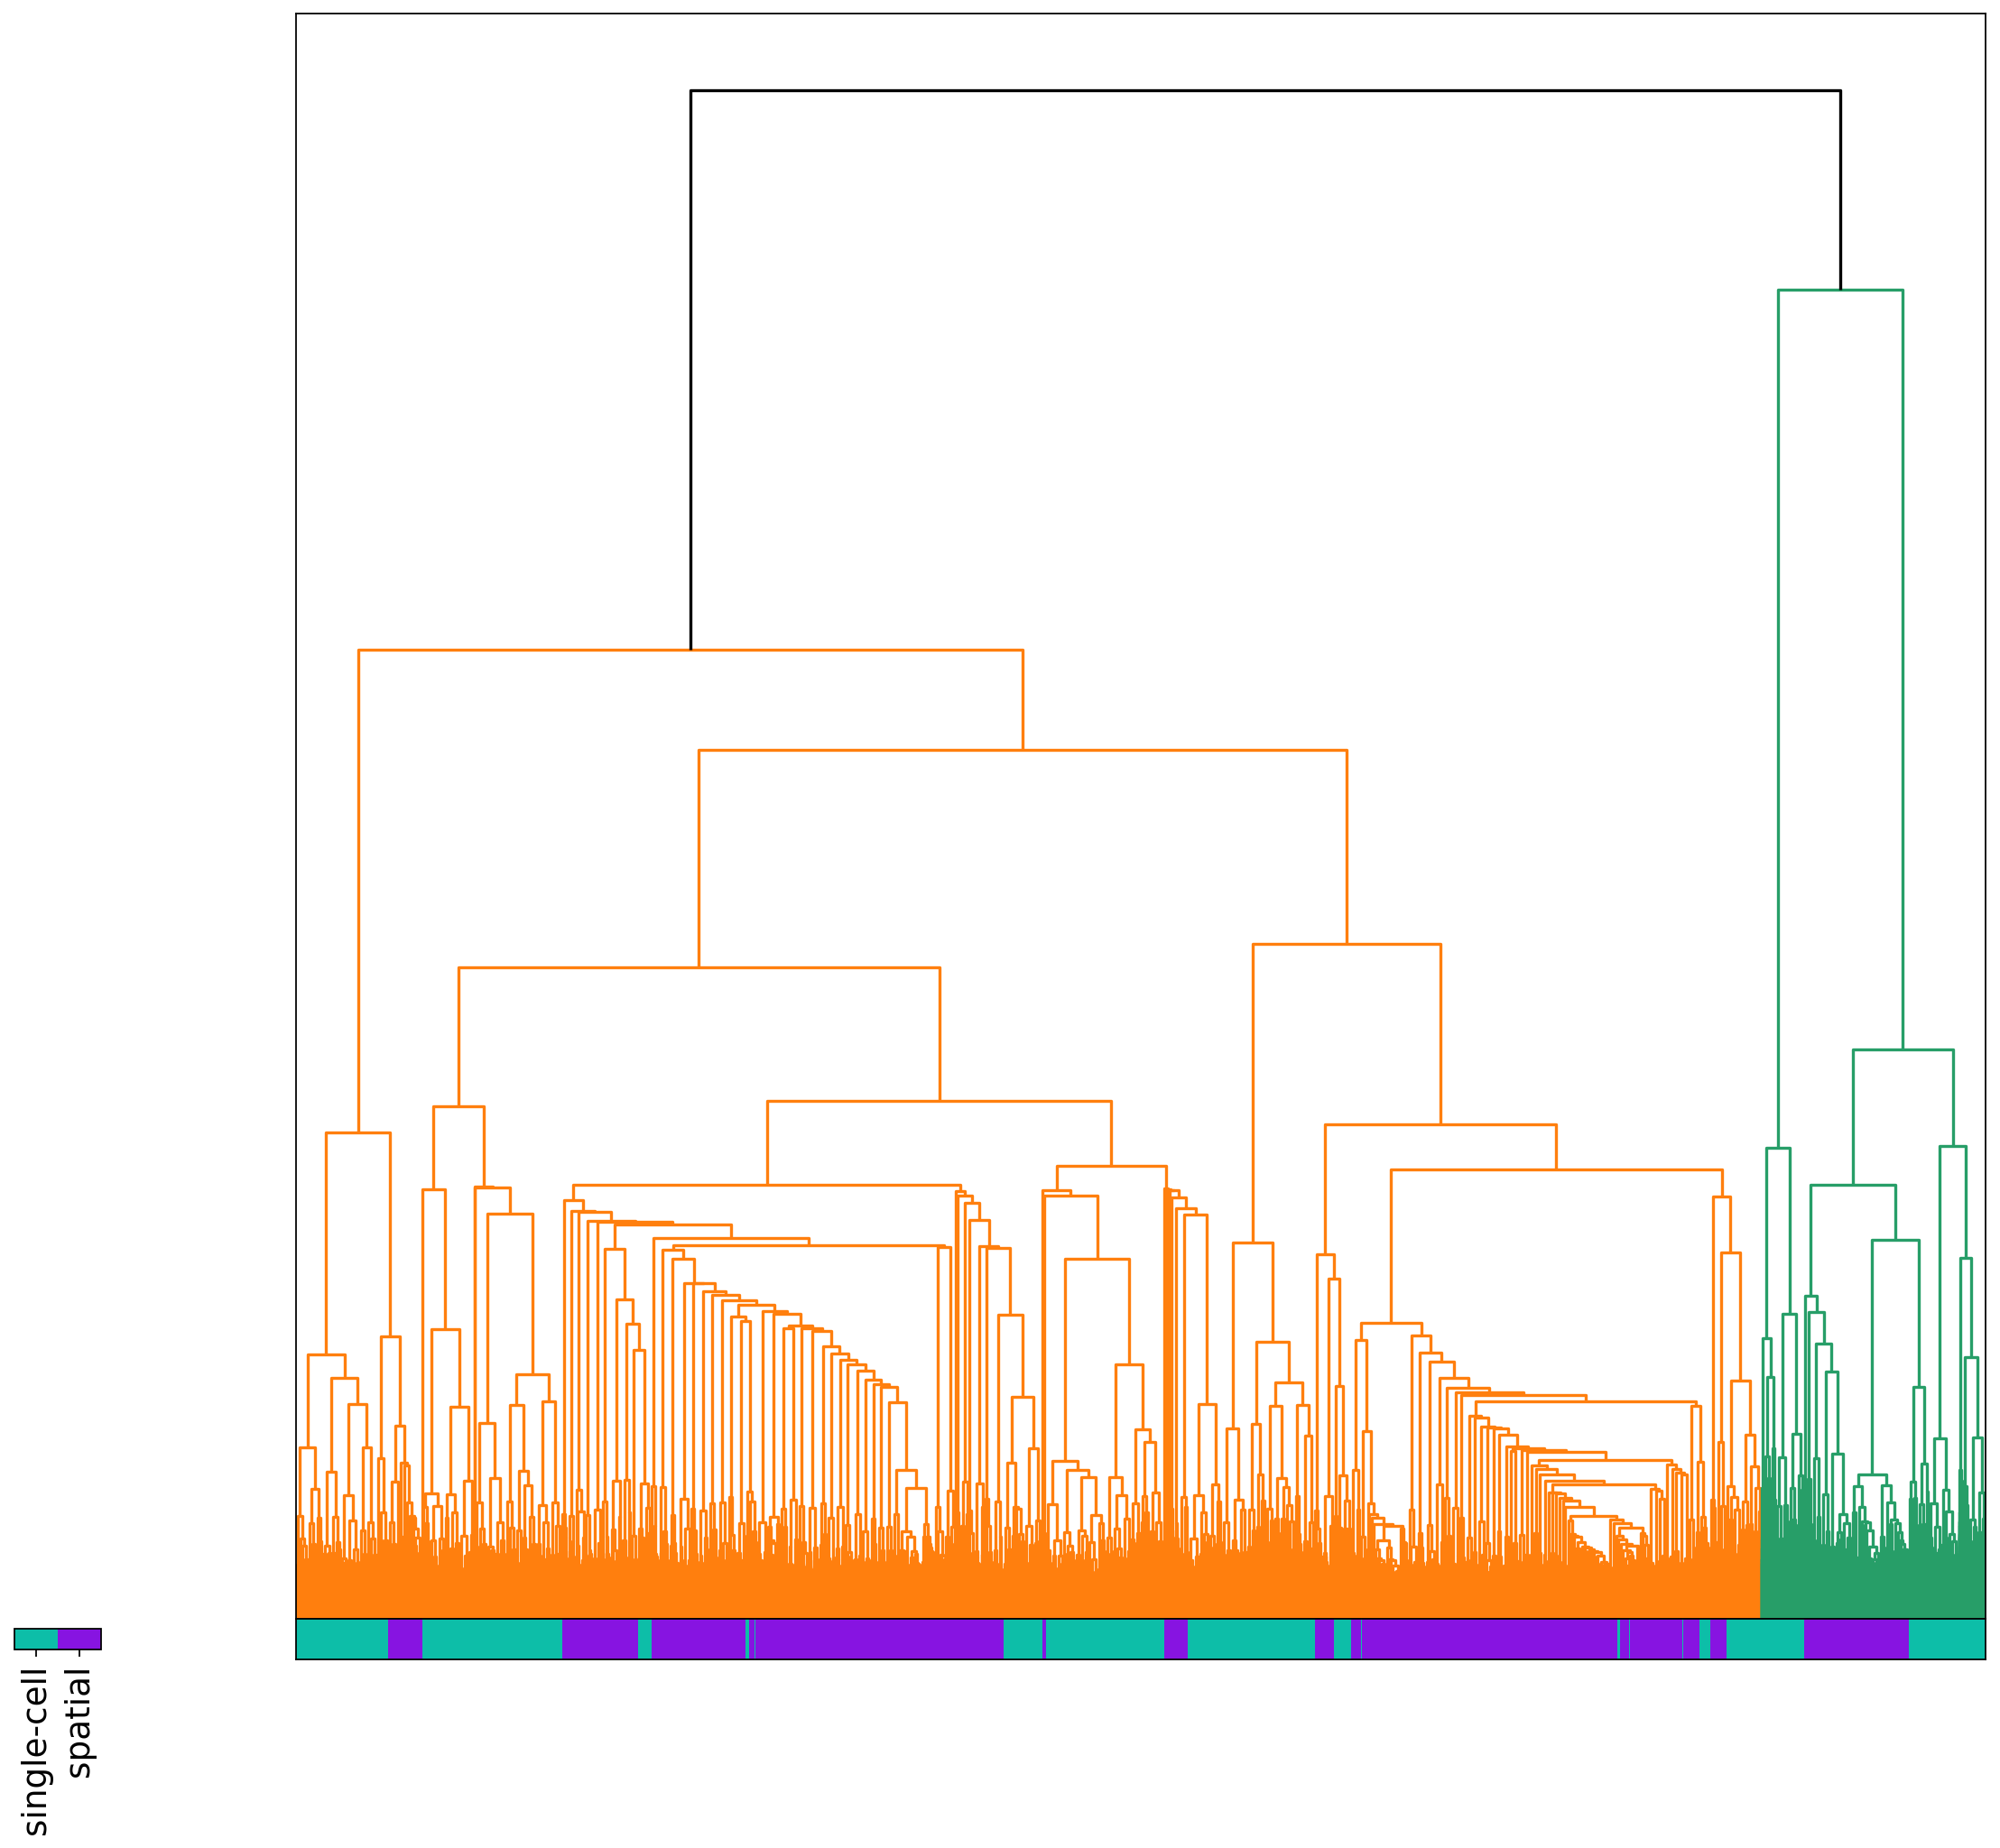

In [ ]:
# # import matplotlib.cm
from sklearn import preprocessing

import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)),
        N=n
    )
    return new_cmap

from matplotlib.colors import rgb2hex
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(2,
                       1,
                       height_ratios=[39, 1],
                       hspace=0.00)

ax2 = fig.add_subplot(gs[0])#add_axes([0,0.75,1,0.45])




clust_labels = all_df.index.get_level_values('domain').to_numpy()
le = preprocessing.LabelEncoder()
clust_labels = le.fit_transform(all_df.index.get_level_values('domain').to_numpy())

Z2 = sch.dendrogram(Z, color_threshold = Z[len(Z) - 2+1,2],  above_threshold_color='k')

ax2.set_xticks([])
ax2.set_yticks([])

# label clusters
clust_labels_dendo = clust_labels[Z2['leaves']]

idx2 = Z2['leaves']





axb = fig.add_subplot(gs[1])


cat_vals = clust_labels[idx2]

n=(~np.isnan(np.unique(cat_vals))).sum()

cmap = plt.cm.get_cmap('bwr', n)
cmap = mcolors.ListedColormap(['#0dbea8', '#8714e1'])

cmap.set_bad('white',1.)

neg = axb.matshow(np.atleast_2d(cat_vals),
                       aspect='auto',
                       origin='lower',
                            cmap=cmap)

pos1 = axb.get_position() # get the original position 
cbaxes = fig.add_axes([0.05, pos1.y0 + pos1.height / 4.0,  0.08*(~np.isnan(np.unique(cat_vals))).sum()/4, pos1.height / 2.0])
ticks = np.unique(cat_vals[~np.isnan(cat_vals)])
cbar = fig.colorbar(neg, cax=cbaxes, orientation='horizontal',
                    ticks=[tick-(tick-ticks.mean())/len(ticks) for tick in ticks])
#                             ticks=ticks
#         tick_locs = (np.arange(n) + 0.5)*(n-1)/n
#         cbar.ax.set_ticks(tick_locs)

cbar.ax.set_xticklabels(le.classes_,rotation=90,fontsize='large')


axb.set_yticks([])
axb.set_xticks([])
    # axb.text(-0.01,
    #      0.5,
    #      cat_bar_var,
    #      horizontalalignment='right',
    #      verticalalignment='center',
    #      transform=bar_axs_cat[i].transAxes,
    #                     fontsize='large'
    #     )
#     bar_axs_cat[i].legend(np.unique(labels[cat_bar_var][[(legend[cat_bar_var][label_name] != 'Indeterminate') for label_name in labels[cat_bar_var]]]).tolist(),
#                           [x for x in legend[cat_bar_var] if x != 'Indeterminate'])
    


#     for vert_po in vert_pos:
#         bar_axs_cat[i].axvline(vert_po, color='k', alpha=1)

# pos_hm = axmatrix.get_position()
# cbaxes = fig.add_axes([0.05, pos_hm.y0+ pos1.height*2, 0.13, pos1.height])  #[left, bottom, width, height]
# cbar = plt.colorbar(im,
#                     cax=cbaxes,
#                     orientation='horizontal',
#                     ticks=[1/(1+np.exp(steeepness*2)),
#                            1/(1+np.exp(steeepness*1)),
#                            1/(1+np.exp(steeepness*0)),
#                            1/(1+np.exp(-steeepness*1)),
#                            1/(1+np.exp(-steeepness*2))])
# cbar.ax.set_xticklabels(['-2', '-1', '0', '1', '2'], fontsize='xx-large')  # vertically oriented colorbar
# cbar.ax.xaxis.tick_left()

# fig.suptitle("\n".join(wrap(f'Dendogram and Heatmap - {params_clust["num_clusters"]} Clusters - subset={subset_str}', 100)),y=0.9)

# plt.savefig(os.path.join(results_dir_out, f'Dendo_heat-{params_clust["num_clusters"]}_clusters.png'), dpi=300)
plt.show(block=False)


In [ ]:
agglo_clust = sch.cut_tree(Z, n_clusters=2).T[0]

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

clf =  RandomForestClassifier(random_state=23, n_jobs=-1)
# clf = SVC(gamma=2, C=1)
# clf = LogisticRegression()



X_train, X_test, y_train, y_test = train_test_split(
    all_df, clust_labels, test_size=0.2, random_state=256
)

clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.score(X_train, y_train)

(1.0, 1.0)

In [ ]:
y_test.mean(), y_train.mean()

(0.5744013511068219, 0.5754139397412311)

In [ ]:
clf = SVC(random_state=20)
# clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.score(X_train, y_train)

In [ ]:
# clf = SVC(gamma=2, C=1)
clf = LogisticRegression(random_state=27)
clf.fit(X_train, y_train)
clf.score(X_test, y_test), clf.score(X_train, y_train)

(0.5744616683756559, 0.5753837801972435)